# Exercises set 7

In [1]:
from qiskit import QuantumCircuit, transpile
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex, plot_histogram
from qiskit_aer import AerSimulator
from itertools import product
from IPython.display import display

In [2]:
ket_0 = np.array([1, 0])
ket_1 = np.array([0, 1])
kets = [ket_0, ket_1]
H_gate = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]])

ket_minus = H_gate @ ket_1
ket_plus = H_gate @ ket_0

## Exercise 1 

[<a href="#ref1">IBMQE</a>]  Challenge Problem: The Deutsch–Jozsa Algorithm

Recall that you previously asked to work out the intermediate qubit states $ \pi_1 $ and $ \pi_2 $ of **Deutsch’s algorithm**.  
Now, do the same for the intermediate $(n + 1)$-qubit states $ \pi_1 $ and $ \pi_2 $ of the **Deutsch–Jozsa algorithm**, for the specific case $ n = 2 $.

Then, verify that

$$
\pi_3 = \ket{-} \otimes 
\sum_{x_0x_1x_2}
(-1)^{f(x_0x_1x_2)} \ket{x_0x_1x_2},
$$

again, for the specific case $ n = 2 $.


### Deutsch's algorithm

We will first study the Deutsch's algorithm simpler scenario. It is described by the following circuit:

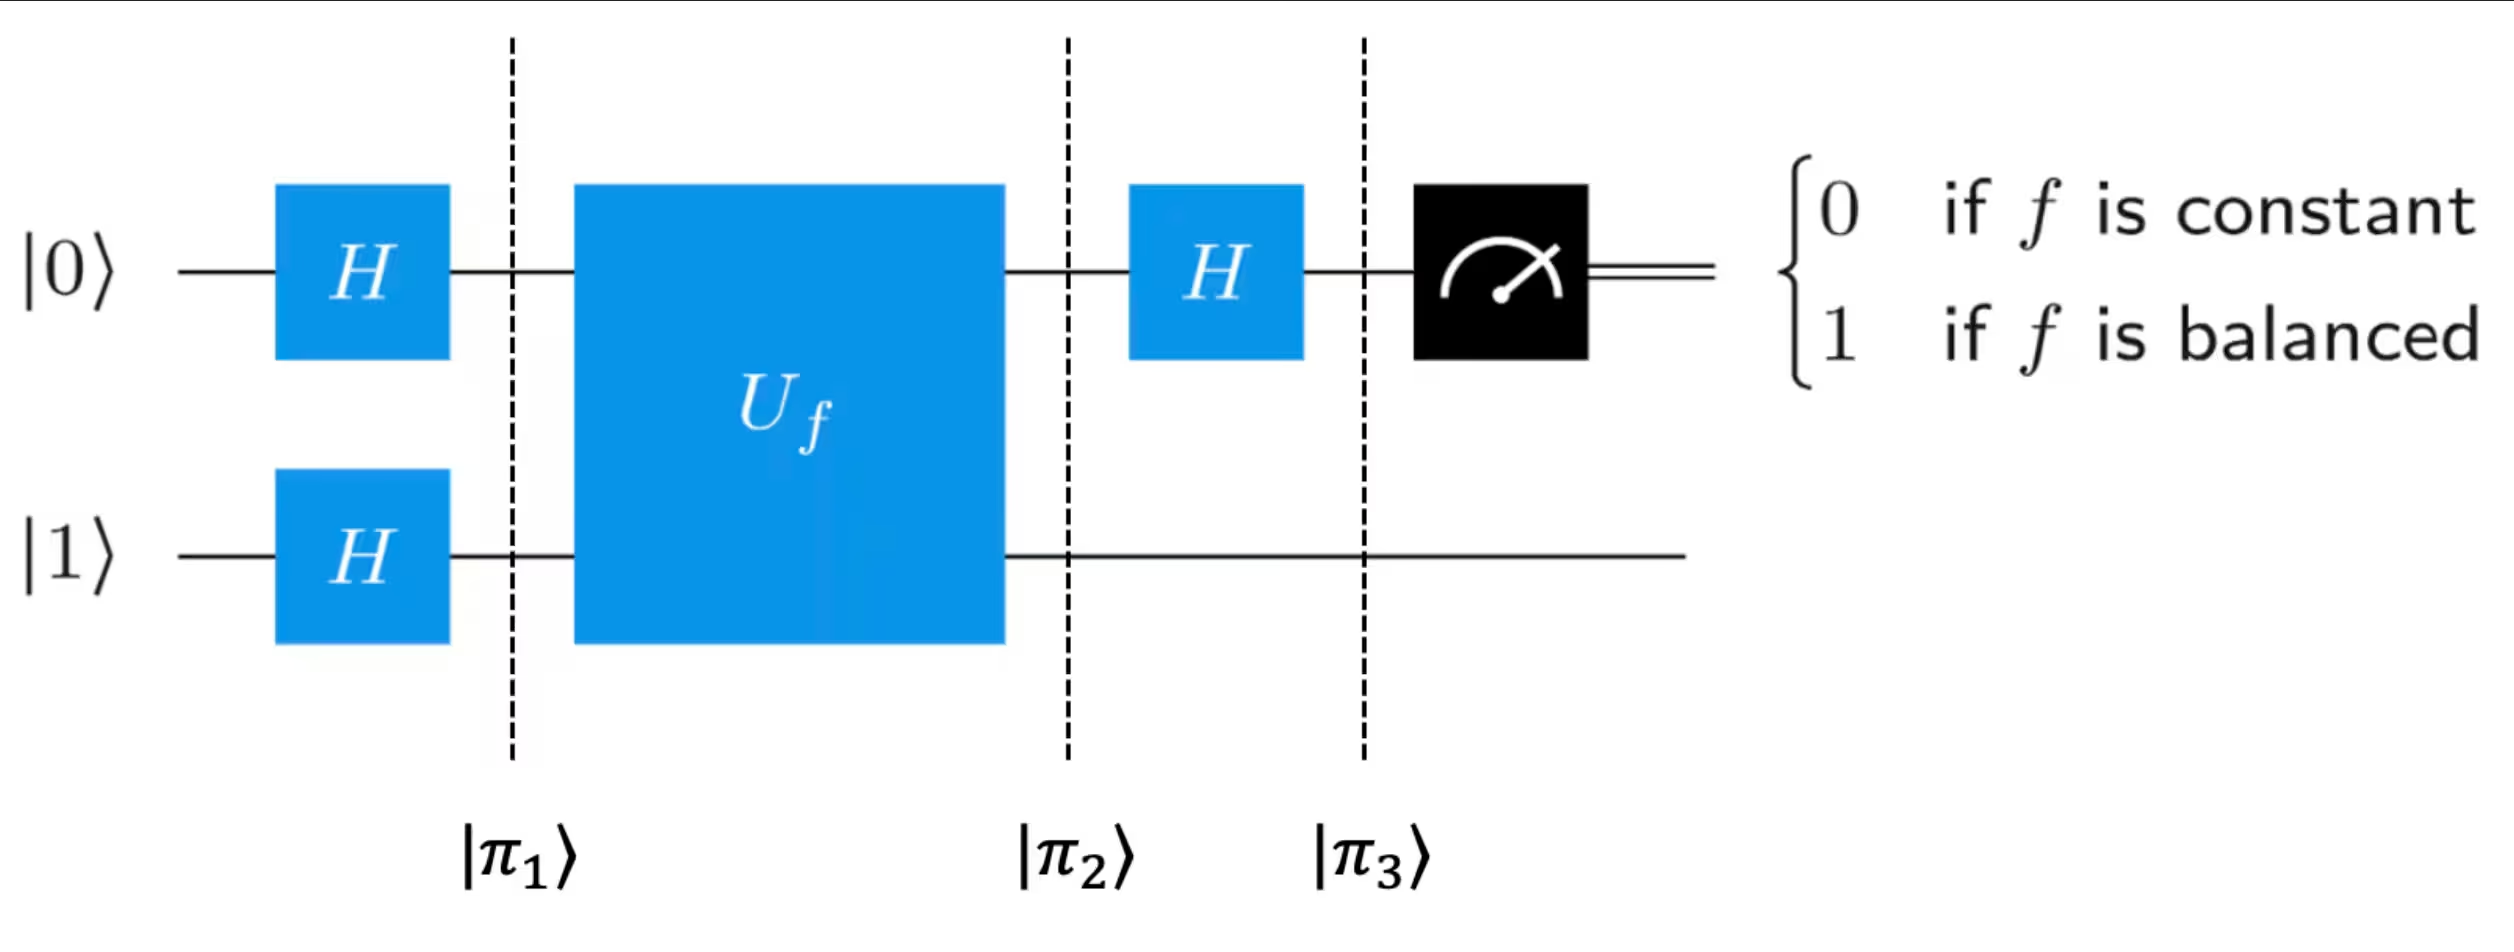

Then, we can describe the different $\pi_i$ states by applying the corresponding gates.

In [3]:
f1 = lambda x: 0
f2 = lambda x: 0 if x == 0 else 1
f3 = lambda x: 1 if x == 0 else 0
f4 = lambda x: 1
f = [f1, f2, f3, f4]


def retreive_pi_states_deutsch(pi_val: int, case: int):
    assert pi_val in [1, 2, 3], "pi_val must be one of 1, 2, or 3"
    assert case in [1, 2, 3, 4], "case must be one of 1, 2, 3, or 4"

    def twobit_function(case: int):
        f = QuantumCircuit(2)
        if case in [2,3]:
            f.cx(0, 1)
        if case in [3,4]:
            f.x(1)
        return f
    
    f_circuit = twobit_function(case)
    
    qc = QuantumCircuit(2)
    qc.x(1)
    qc.h(range(2))
    if pi_val == 1:
        return Statevector.from_instruction(qc).data
    qc.compose(f_circuit, inplace=True)
    if pi_val == 2:
        return Statevector.from_instruction(qc).data
    qc.h(0)
    if pi_val == 3:
        return Statevector.from_instruction(qc).data

#### $\pi_1$



For this state, we will just apply the dot product between $\ket{10}$ and $H \otimes H$. Which leads to:

$$\begin{align*}
       \pi_1 &= (H \otimes H) \cdot \ket{10} \\
        &=  H \ket{1} \otimes H \ket{0} \\
        & = \left(\frac{\ket{0} - \ket{1}}{\sqrt{2}}\right) \otimes \left(\frac{\ket{0} + \ket{1}}{\sqrt{2}}\right) \\
        & = \frac{1}{2} (\ket{0} - \ket{1}) \otimes (\ket{0} + \ket{1}) \\
        & = \frac{1}{2} (  (\ket{0} - \ket{1}) \otimes \ket{0} + (\ket{0} - \ket{1}) \otimes \ket{1}  ) \\
        & = \frac{1}{2} \sum_{x \in \{0,1\}} (\ket{0} - \ket{1}) \otimes \ket{x} \\
        & = \frac{1}{\sqrt{2}} \sum_{x \in \{0,1\}} \ket{-,x} \\
        & = \frac{1}{2} (\ket{00} +  \ket{01} - \ket{10} - \ket{11}) \\
        & = \frac{1}{2} [\,\,1 \quad 1 \quad -1 \quad -1\,\,]
\end{align*}$$

In [4]:
pi_1 = np.kron(H_gate, H_gate) @ np.kron(ket_1, ket_0)

# Assertions for pi_1
for i in range(1, 5):
    pi_states = retreive_pi_states_deutsch(1,i)
    assert np.allclose(pi_states, pi_1), f"Test for pi_1 failed in case {i}"

display(array_to_latex(pi_1, prefix="f_i \\text{  and  } \\pi_1 = "))

<IPython.core.display.Latex object>

#### $\pi_2$

For this state, we will take previous $\pi_1$ and we will apply the $U_f$ operator that applies $U_f \ket{y, x} = \ket{y \oplus f(x), x}$. This is done by applying a $CNOT$, then we will be able to use the result ($q_0$ is the control and $q_1$ the target):

$$
CNOT \ket{y,x} = \ket{y \oplus x , x} \Longleftrightarrow CNOT \ket{-,x} = (-1)^{x} \ket{- , x}
$$


Substituting:

$$\begin{align*}
       \pi_2 &= U_f \pi_1 \\
             &= U_f \frac{1}{\sqrt{2}} \sum_{x \in \{0,1\}} \ket{-,x} \\
             &=  \frac{1}{\sqrt{2}} \sum_{x \in \{0,1\}} U_f \ket{-,x} \\
             &=  \frac{1}{\sqrt{2}} \sum_{x \in \{0,1\}} (-1)^{f(x)} \ket{-,x} \\
             &=  \frac{1}{\sqrt{2}} \ket{-} \otimes \sum_{x \in \{0,1\}} (-1)^{f(x)} \ket{x} \\
\end{align*}$$

In [5]:
# Assertions for pi_2
for i in range(1, 5):
    pi_states = retreive_pi_states_deutsch(2,i)
    f_i = f[i-1]
    pi2_sum = np.zeros_like(ket_0)
    for x in [0, 1]:
        fx = f_i(x)
        pi2_sum += (-1)**fx * kets[x]
    pi_2 = (1/np.sqrt(2)) * np.kron(ket_minus, pi2_sum)
    assert np.allclose(pi_states, pi_2), f"Test for pi_2 failed in case {i}"
    display(array_to_latex(pi_states, prefix=f"f_{i} \\text{{  and  }} \\pi_2 = "))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### $\pi_3$

Now we will start from state $\pi_2$ and we will apply $H-$ gate to the control qubit $q_0$.

$$\begin{align*}
       \pi_3 &= (I \otimes H) \cdot \pi_2 \\
             &= (I \otimes H) \cdot \left( \frac{1}{\sqrt{2}} \ket{-} \otimes \sum_{x \in \{0,1\}} (-1)^{f(x)} \ket{x} \right) \\
             &= \frac{1}{\sqrt{2}}\left( I \ket{-} \otimes H \sum_{x \in \{0,1\}} (-1)^{f(x)} \ket{x} \right) \\
             &= \frac{1}{\sqrt{2}}\left( I \ket{-} \otimes \sum_{x \in \{0,1\}} (-1)^{f(x)} H \ket{x} \right) \\
             &= \frac{1}{\sqrt{2}}\left(\ket{-} \otimes ((-1)^{f(0)} \ket{+} + (-1)^{f(1)} \ket{-}) \right) \\
             &= \frac{1}{\sqrt{2}}\left((-1)^{f(0)} \ket{-+} + (-1)^{f(1)} \ket{--} \right) \\
\end{align*}$$

Now if we write $\ket{--}$ and $\ket{-+}$ in the canonical basis.

$$\ket{--} = \left(\dfrac{\ket{0} - \ket{1}}{\sqrt{2}}\right) \otimes \left(\dfrac{\ket{0} - \ket{1}}{\sqrt{2}}\right) = 
\dfrac{1}{2} (\ket{00} - \ket{01} - \ket{10} + \ket{11})$$

$$\ket{-+} = \left(\dfrac{\ket{0} - \ket{1}}{\sqrt{2}}\right) \otimes \left(\dfrac{\ket{0} + \ket{1}}{\sqrt{2}}\right) = 
\dfrac{1}{2} (\ket{00} + \ket{01} - \ket{10} - \ket{11})$$

Substituting into $\pi_3$:

$$
\begin{aligned}
\pi_3
&= \frac{1}{2\sqrt{2}}\Big(
   [(-1)^{f(0)}+(-1)^{f(1)}]\ket{00}
 + [(-1)^{f(0)}-(-1)^{f(1)}]\ket{01} \\
&\quad
 -[(-1)^{f(0)}+(-1)^{f(1)}]\ket{10}
 +[-(-1)^{f(0)}+(-1)^{f(1)}]\ket{11}
\Big).
\end{aligned}
$$

Grouping by the control qubit ($q_0$):

$$
\begin{aligned}
P(q_0=0) &= \frac{[(-1)^{f(0)}+(-1)^{f(1)}]^2}{4} \\
P(q_0=1) &= \frac{[(-1)^{f(0)}-(-1)^{f(1)}]^2}{4}.
\end{aligned}
$$

$$
\begin{cases}
f(0)=f(1) &\Rightarrow\; P(q_0=0)=1,\; P(q_0=1)=0 \\
f(0)\neq f(1) &\Rightarrow\; P(q_0=0)=0,\; P(q_0=1)=1.
\end{cases}
$$

Hence the measurement on $q_0$ deterministically distinguishes:

$$
\boxed{
q_0 = 0 \;\text{if $f$ is constant},\qquad
q_0 = 1 \;\text{if $f$ is balanced.}
}
$$


In [6]:
# Assertions for pi_3
for i in range(1, 5):
    pi_states = retreive_pi_states_deutsch(3,i)
    f_i = f[i-1]
    pi_3 = np.full_like(pi_states, np.sqrt(2)/2)
    pi_3*= ( (-1)**f_i(0) * np.kron(ket_minus, ket_plus) + (-1)**f_i(1) * np.kron(ket_minus, ket_minus) )
        
    assert np.allclose(pi_states, pi_3), f"Test for pi_3 failed in case {i}"
    display(array_to_latex(pi_states, prefix=f"f_{i} \\text{{  and  }} \\pi_3 = "))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Deutsch-Josza algorithm

We will now study the Deutsch-Josza algorithm scenario. It is described by the following circuit:

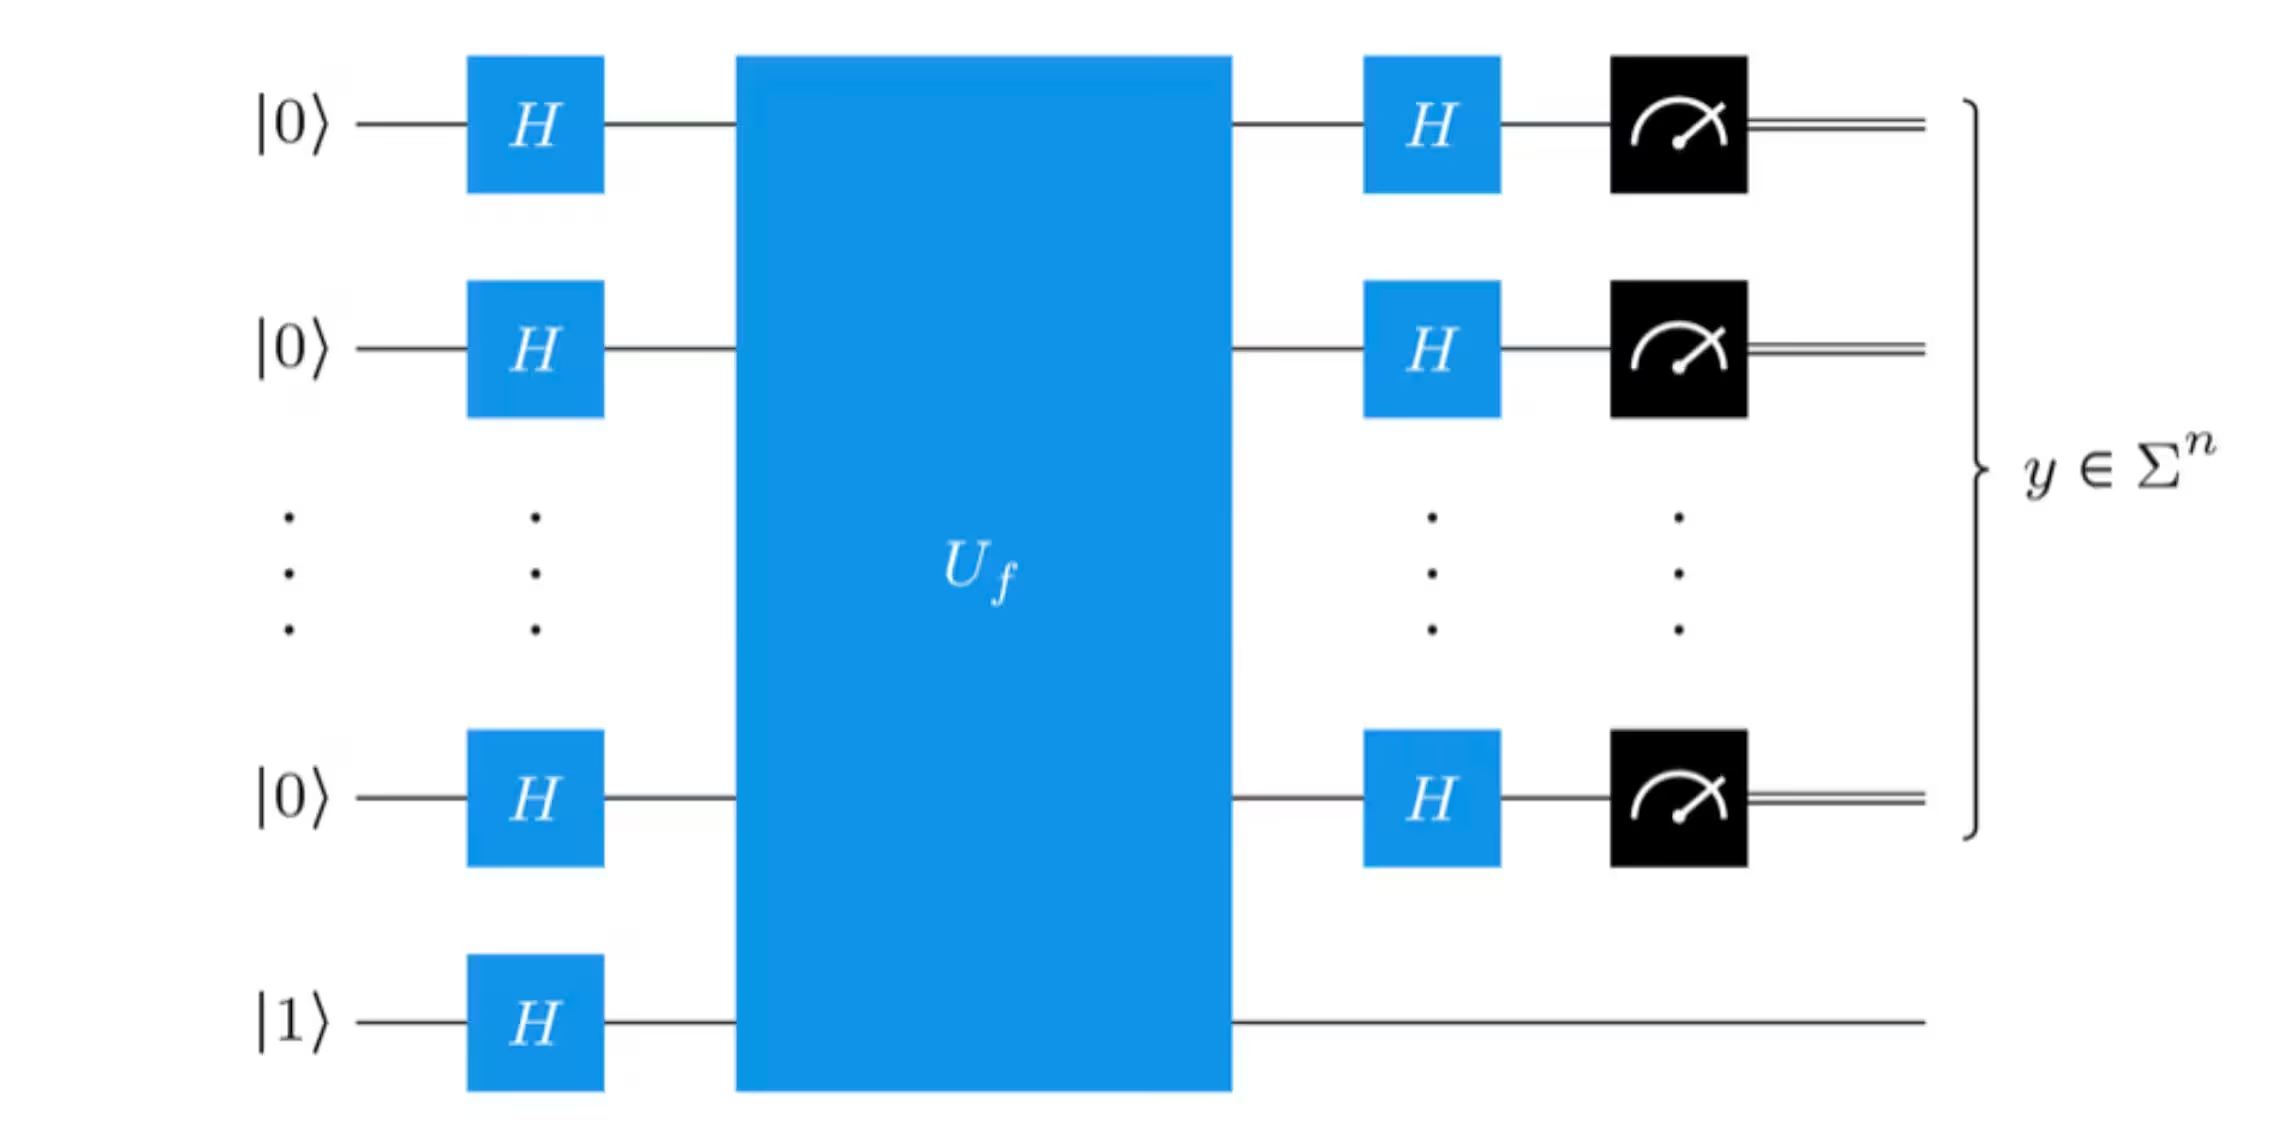


Then, we can describe the $\pi_1$ and $\pi_2$ states by applying the corresponding gates.

In [7]:
def retreive_pi_states_deutsch_josza(pi_val: int, num_qubits: int = 2, verbose = False):
    """
    Returns the Deutsch-Jozsa state for pi_val = 1, 2, or 3:
    1 -> initial state after H on all qubits and X on ancilla
    2 -> state after DJ oracle, before final Hadamard on main qubits (returns also f)
    3 -> final state after full Deutsch-Jozsa algorithm (returns also f)
    """

    assert pi_val in [1, 2, 3], "pi_val must be one of 1, 2, or 3"

    # --- Deutsch-Jozsa oracle generator ---
    def dj_function(num_qubits, verbose=False):
        """
        Generates a random Deutsch–Jozsa function f and its quantum oracle circuit,
        consistent with Qiskit's little-endian convention.

        The oracle U_f acts as:
            U_f |y, x> = |y ⊕ f(x), x|
        and when |y> = |->, produces phase kickback:
            U_f |-, x> = (-1)^{f(x)} |-, x>

        f receives bits in *little-endian order*, i.e.:
            f(q_{n-1}, ..., q_0)
        where q_0 corresponds to qubit 0 (LSB).
        """
        qc_dj = QuantumCircuit(num_qubits + 1)
        v = 0  # For constant functions

        # Randomly decide if function is constant
        if np.random.randint(0, 2):
            qc_dj.x(num_qubits)
            v = 1
        if np.random.randint(0, 2):
            # Return constant function
            f = lambda *args: v
            if verbose:
                print(f"Generated constant function f(x) = {v}")
            return qc_dj, f

        # Otherwise, balanced function
        on_states = np.random.choice(range(2**num_qubits), 2**num_qubits // 2, replace=False)

        # Helper: Apply X gates to select the proper computational basis state
        def add_cx(qc, bit_string):
            for qubit, bit in enumerate(reversed(bit_string)):  # reversed due to little endian in Qiskit
                if bit == "1":
                    qc.x(qubit)
            return qc

        for state in on_states:
            bit_str = f"{state:0{num_qubits}b}"
            qc_dj = add_cx(qc_dj, bit_str)
            qc_dj.mcx(list(range(num_qubits)), num_qubits)
            qc_dj = add_cx(qc_dj, bit_str)

        # Define classical function f in little-endian order
        # f(q_{n-1}, ..., q_0) with q_0 as LSB
        on_states_set = set(on_states)
        f = lambda *bits: int(sum(b * (2**i) for i, b in enumerate(bits)) in on_states_set)

        if verbose:
            print(f"Generated balanced function with 'on' states: "
                f"{[f'{s:0{num_qubits}b}' for s in on_states]}")

        return qc_dj, f

    # --- Build initial circuit ---
    qc = QuantumCircuit(num_qubits + 1)
    qc.x(num_qubits)           # Flip ancilla |0> -> |1>
    qc.h(range(num_qubits + 1))  # Hadamard on all qubits

    if pi_val == 1:
        return Statevector.from_instruction(qc).data

    # Compose Deutsch-Jozsa oracle
    dj_circuit, f = dj_function(num_qubits, verbose=verbose)
    qc.compose(dj_circuit, inplace=True)

    if pi_val == 2:
        return Statevector.from_instruction(qc).data, f

    # Final Hadamard on main qubits for Deutsch-Jozsa
    qc.h(range(num_qubits))
    if pi_val == 3:
        return Statevector.from_instruction(qc).data, f

#### $\pi_1$

In this scenario with $(n+1)$-qubits, the state $\pi_1$ is described as the first $n$ qubits initialized in $0$ and last qubit in $1$ with $H$-gate applied in all of them.

$$
\begin{aligned}
    \pi_1^{(n)}
    &= (H^{\otimes (n+1)})\,\ket{10\ldots0} \\
    &= \big(H\ket{1}\big)\otimes\big(H^{\otimes n}\ket{0\ldots0}\big) \\
    &= \ket{-}\otimes\ket{+}^{\otimes n} =  \ket{-+\dots+} \\
    &= \ket{-}\otimes\dfrac{1}{\sqrt{2^n}}\sum_{x\in\{0,1\}^n}\ket{x} = \dfrac{1}{\sqrt{2^n}}\sum_{x\in\{0,1\}^n}\ket{-,x}\\
    &= \dfrac{\ket{0} - \ket{1}}{\sqrt{2}}\otimes\left(\dfrac{1}{\sqrt{2^n}}\sum_{x\in\{0,1\}^n}\ket{x}\right) \\
    &= \dfrac{1}{\sqrt{2^{n+1}}}\sum_{x\in\{0,1\}^n}\ket{0x} - \ket{1x} \\
\end{aligned}
$$

For the particular scenario $n=2$, we have:

$$\pi_1^{(2)} = \dfrac{\sqrt{2}}{4} \left( \ket{000} + \ket{001} + \ket{010} + \ket{011} - \ket{100} - \ket{101} - \ket{110} - \ket{111} \right)$$

In [8]:
pi_1 = np.kron(np.kron(H_gate, H_gate), H_gate) @ np.kron(ket_1, np.kron(ket_0, ket_0))
assert np.allclose(retreive_pi_states_deutsch_josza(1,2), pi_1)

array_to_latex(pi_1, prefix="\\pi_1^{(2)} = ")

<IPython.core.display.Latex object>

#### $\pi_2$

We will use the definitoon of $U_f$ as $U_f \ket{y,x} = \ket{y \oplus f(x), x}$ where $x$ is a sequence in $\{0,1\}^n$. Which means that $\ket{xy} = \ket{x,y}$ is a $(n+1)$-qubits ket. Here, we will use again phase kickback trick defined over $CNOT$ as:

$$
CNOT \ket{y,x} = \ket{y \oplus x , x} \Longleftrightarrow CNOT \ket{-,x} = (-1)^{x} \ket{- , x}
$$

Leading to the following result:

$$

\begin{aligned}
    \pi_2 
        & = U_f \cdot \pi_1 \\
        & = U_f \left( \dfrac{1}{\sqrt{2^n}} \sum_{x\in\{0,1\}^n} \ket{-,x} \right) \\
        & = \dfrac{1}{\sqrt{2^n}} \sum_{x\in\{0,1\}^n} U_f \ket{-,x} \\
        & = \dfrac{1}{\sqrt{2^n}} \sum_{x\in\{0,1\}^n} (-1)^{f(x)} \ket{-,x} \\
        & = \dfrac{1}{\sqrt{2^n}} \ket{-} \otimes  \sum_{x\in\{0,1\}^n} (-1)^{f(x)} \ket{x}.
\end{aligned}


$$


In [9]:
def construct_pi_right(f, num_qubits):
    pi_right = np.zeros(2**num_qubits, dtype=complex)

    for bits in product([0, 1], repeat=num_qubits):
        fx = f(*reversed(bits))
        ket_x = kets[bits[0]]
        for b in bits[1:]:
            ket_x = np.kron(ket_x, kets[b])
        pi_right += (-1)**fx * ket_x
    return pi_right



pi_2, f = retreive_pi_states_deutsch_josza(2,2, verbose=True)
pi2_right = construct_pi_right(f, 2)

pi2_analytical = (1/np.sqrt(2**2)) * np.kron(ket_minus, pi2_right)
assert np.allclose(pi_2, pi2_analytical) or np.allclose(pi_2, -pi2_analytical), \
       f"{pi_2} differs from {pi2_analytical}"

display(array_to_latex(pi_2, prefix="\\pi_2^{(2)} = "))
    

Generated balanced function with 'on' states: ['10', '01']


<IPython.core.display.Latex object>

#### $\pi_3$

Now we will apply the Hadarmad gates to input qubits after state $\pi_2$ in order to retreive the criteria for balanced and constant functions.

$$
\begin{aligned}
    \pi_3 ^{(n)}
        & = (I \otimes H^{\otimes n}) \cdot \pi_2 \\
        & = (I \otimes H^{\otimes n}) 
            \left( \dfrac{1}{\sqrt{2^n}} \ket{-} \otimes 
            \sum_{x\in\{0,1\}^n} (-1)^{f(x)} \ket{x} \right) \\
        & = \dfrac{1}{\sqrt{2^n}} \ket{-} \otimes 
            H^{\otimes n} \sum_{x\in\{0,1\}^n} (-1)^{f(x)} \ket{x} \\
        & = \dfrac{1}{\sqrt{2^n}} \ket{-} \otimes  
            \sum_{x\in\{0,1\}^n} (-1)^{f(x)} 
            \left( \dfrac{1}{\sqrt{2^n}} 
            \sum_{y\in\{0,1\}^n} (-1)^{x \cdot y} \ket{y} \right) \\
        & = \dfrac{1}{2^n} \ket{-} \otimes 
            \sum_{y\in\{0,1\}^n} 
            \left( \sum_{x\in\{0,1\}^n} 
            (-1)^{f(x) + x \cdot y} \right) \ket{y}.
\end{aligned}
$$

When we apply the particular case $n=2$

$$
\begin{aligned}
\pi_3^{(2)}
&= \frac{1}{4}\ket{-}\otimes
   \sum_{y\in\{00,01,10,11\}}
   \Biggl(\sum_{x\in\{00,01,10,11\}} (-1)^{\,f(x)+x\cdot y}\Biggr)\ket{y} \\
&= \frac{1}{4}\ket{-}\otimes\Biggl(
    S(00)\ket{00} + S(01)\ket{01} + S(10)\ket{10} + S(11)\ket{11}
   \Biggr),
\end{aligned}
$$
where
$$
\begin{aligned}
S(00) &= (-1)^{f(00)} + (-1)^{f(01)} + (-1)^{f(10)} + (-1)^{f(11)},\\
S(01) &= (-1)^{f(00)} - (-1)^{f(01)} + (-1)^{f(10)} - (-1)^{f(11)},\\
S(10) &= (-1)^{f(00)} + (-1)^{f(01)} - (-1)^{f(10)} - (-1)^{f(11)},\\
S(11) &= (-1)^{f(00)} - (-1)^{f(01)} - (-1)^{f(10)} + (-1)^{f(11)}.
\end{aligned}
$$

Equivalently, writing out every term explicitly,
$$
\begin{aligned}
\pi_3^{(2)} &= \frac{1}{4}\ket{-}\otimes\Bigl(
\bigl[(-1)^{f(00)}+(-1)^{f(01)}+(-1)^{f(10)}+(-1)^{f(11)}\bigr]\ket{00} \\[4pt]
&\qquad\quad+\bigl[(-1)^{f(00)}-(-1)^{f(01)}+(-1)^{f(10)}-(-1)^{f(11)}\bigr]\ket{01} \\[4pt]
&\qquad\quad+\bigl[(-1)^{f(00)}+(-1)^{f(01)}-(-1)^{f(10)}-(-1)^{f(11)}\bigr]\ket{10} \\[4pt]
&\qquad\quad+\bigl[(-1)^{f(00)}-(-1)^{f(01)}-(-1)^{f(10)}+(-1)^{f(11)}\bigr]\ket{11}
\Bigr).
\end{aligned}
$$


In [10]:
pi3, f = retreive_pi_states_deutsch_josza(3,2, verbose=True)

def x_dot_y(x, y):
    """Binary dot product x·y mod 2."""
    return sum(a * b for a, b in zip(x, y)) % 2

def target_to_check_2(f):
    """
    Computes the full Deutsch–Jozsa final state π₃^(2):

        π₃^(2) = (1/2^2) |−⟩ ⊗ Σ_y [ Σ_x (-1)^{f(x) + x·y} |y⟩ ]

    Parameters
    ----------
    f : callable
        Boolean function f(x0, x1) ∈ {0, 1}.

    Returns
    -------
    np.ndarray
        The 3-qubit final state vector (dimension 8).
    """
    n = 2
    right_side = np.zeros(2**n, dtype=complex)
    for y_bits in product([0, 1], repeat=n):
        inner_sum = 0
        for x_bits in product([0, 1], repeat=n):
            fx = f(*reversed(x_bits))
            inner_sum += (-1) ** (fx + x_dot_y(x_bits, y_bits))
        ket_y = np.kron(kets[y_bits[0]], kets[y_bits[1]])
        right_side += inner_sum * ket_y
    right_side /= 2**n
    return np.kron(ket_minus, right_side)

assert np.allclose(pi3, target_to_check_2(f)) or np.allclose(pi3, -target_to_check_2(f)), f"{pi3} differs from target state"
array_to_latex(pi3, prefix="\\pi_3^{(2)} = ")


Generated constant function f(x) = 0


<IPython.core.display.Latex object>

What about:

$$
\pi_3 = \ket{-} \otimes 
\sum_{x_0x_1x_2}
(-1)^{f(x_0x_1x_2)} \ket{x_0x_1x_2},
$$

for $n=2$?

In first place, the expression shown manages $4$-qubits, then for being coherent in $n=2$, we change it for:

$$
\pi_3 = \ket{-} \otimes 
\sum_{x_0x_1}
(-1)^{f(x_0x_1)} \ket{x_0x_1},
$$

This expression is not correct for the scenario described by the circuit and the algorithm. In order to proof this, we just need to take a particular case, we will use $f(x) = 0$ (Constant function).

This scenario in the algorithm is modeled by the following circuit:

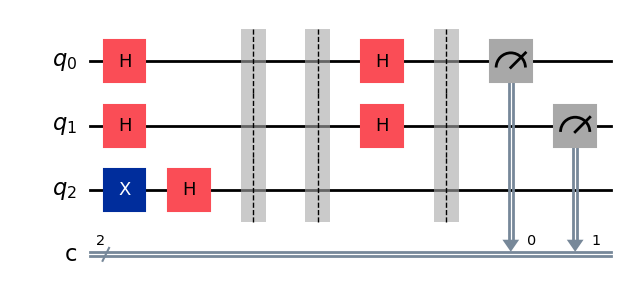

In [11]:
qc_0 = QuantumCircuit(3,2)
qc_0.x(2)
qc_0.h(range(3))
qc_0.barrier()
qc_0.barrier()
qc_0.h(range(2))
qc_0.barrier()
qc_0.measure(range(2), range(2))
qc_0.draw('mpl')

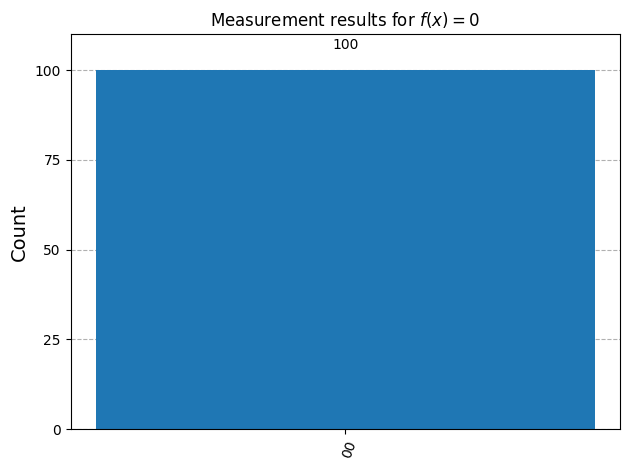

In [12]:
sim = AerSimulator()
compiled_qc = transpile(qc_0, sim)
result = sim.run(compiled_qc, shots=100).result()
counts = result.get_counts()
plot_histogram(counts, title='Measurement results for $f(x)=0$')

Now let's see what happens if we use the formula given

In [13]:
def get_wrong_pi3(f):
    num_qubits = 2
    pi_3_wrong = np.zeros(2**(num_qubits + 1), dtype=complex)

    for bits in product([0, 1], repeat=num_qubits):
        fx = f(*reversed(bits))
        ket_x = kets[bits[0]]
        for b in bits[1:]:
            ket_x = np.kron(ket_x, kets[b])
        pi_3_wrong += (-1)**fx * np.kron(ket_minus, ket_x)
    # Attention! It was needed to normalize the state as it did not meet
    # the minimum requirement of a quantum state
    pi_3_wrong /= np.sqrt(2**num_qubits)
    return pi_3_wrong

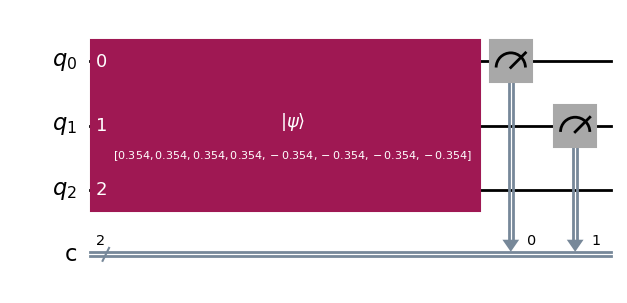

In [14]:
f = lambda x0, x1: 0
pi3_vec = get_wrong_pi3(f)

qc = QuantumCircuit(3, 2)
qc.initialize(pi3_vec, range(3))
qc.measure(range(2), range(2))
qc.draw('mpl')

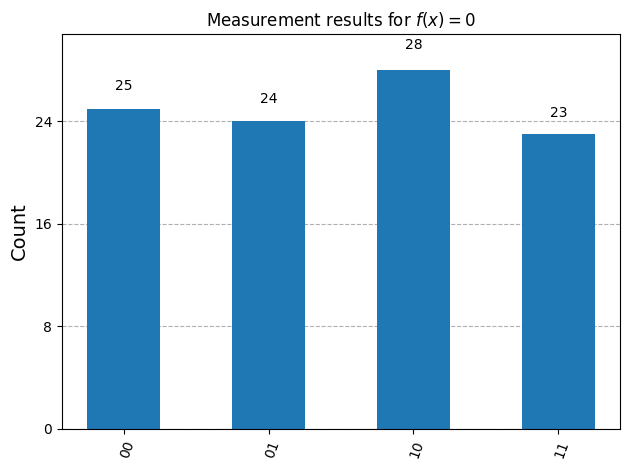

In [15]:
sim = AerSimulator()
compiled_qc = transpile(qc, sim)
result = sim.run(compiled_qc, shots=100).result()
counts = result.get_counts()
plot_histogram(counts, title='Measurement results for $f(x)=0$')

As we see, measuring in this purposed state, we just get a non-meaningful result that can't answer the problem given for Deutsch-Josza algorithm

## References
[IBMQE] <a id="ref1"></a>   Quantum Platform Courses: Deutsch-Jozsa Algorithm (https://quantum.cloud.ibm.com/learning/en/modules/computer-science/deutschjozsa)